# Neural Networks with MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prepare MNIST Data

In [3]:
train_data = dsets.MNIST(root='data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

test_data = dsets.MNIST(root='data/',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


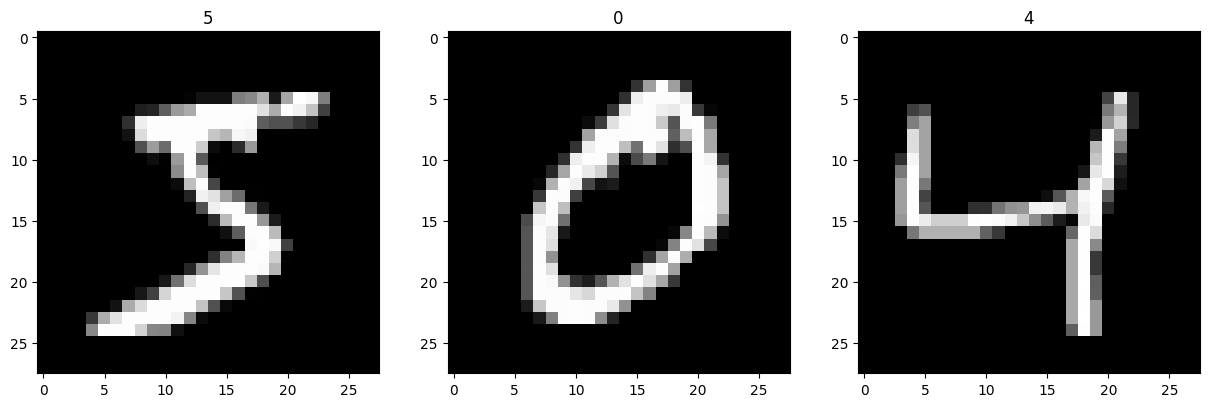

In [4]:
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.set_title(train_data.targets[0].item())
ax1.imshow(train_data.data[0,:,:].numpy(), cmap='gray')

ax2.set_title(train_data.targets[1].item())
ax2.imshow(train_data.data[1,:,:].numpy(), cmap='gray')

ax3.set_title(train_data.targets[2].item())
ax3.imshow(train_data.data[2,:,:].numpy(), cmap='gray')

## 2. Make Batch Loader

In [5]:
batch_size = 100

train_loader  = DataLoader(dataset=train_data,
                           batch_size=batch_size,
                           shuffle=True)

In [6]:
batch_images, batch_labels = next(iter(train_loader))
print(batch_labels.numpy(), ", ", len(batch_labels.numpy()))

[3 4 3 6 3 9 2 7 1 7 9 0 6 1 6 5 3 8 4 6 3 6 7 7 2 5 5 4 9 3 7 7 8 1 2 0 8
 6 9 4 2 0 4 0 3 3 0 5 1 3 6 1 2 3 2 1 8 3 3 6 0 0 2 1 7 5 5 8 1 4 4 7 1 6
 3 4 8 4 2 8 9 4 1 8 2 9 6 4 7 8 2 4 5 6 6 2 5 1 6 0] ,  100


## 3. Define Model

In [7]:
model = nn.Sequential(
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

In [8]:
loss = nn.CrossEntropyLoss()

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

## 4 Train Model

In [10]:
num_epochs = 5

In [11]:
## 오래걸림
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images.view(-1, 28 * 28)
        Y = batch_labels

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

print("Learning Finished!")

Epoch [1/5], lter [300/600], Loss: 2.2512
Epoch [1/5], lter [600/600], Loss: 2.1906
Epoch [2/5], lter [300/600], Loss: 2.0891
Epoch [2/5], lter [600/600], Loss: 1.9942
Epoch [3/5], lter [300/600], Loss: 1.9456
Epoch [3/5], lter [600/600], Loss: 1.8104
Epoch [4/5], lter [300/600], Loss: 1.6487
Epoch [4/5], lter [600/600], Loss: 1.6136
Epoch [5/5], lter [300/600], Loss: 1.4885
Epoch [5/5], lter [600/600], Loss: 1.2886
Learning Finished!


## 5. Test Model

In [12]:
correct = 0
total = 0

for images, labels in test_data:

    images  = images.view(-1, 28 * 28)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += 1
    correct += (predicted == labels).sum()

print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 79.060000 %


In [13]:
r = random.randint(0, len(test_data)-1)
X_single_data = test_data.data[r:r + 1].view(-1,28*28).float()
Y_single_data = test_data.targets[r:r + 1]

Label :  [7]
Prediction :  [1]


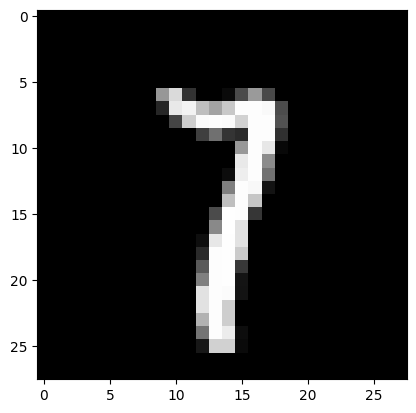

In [14]:
single_pre = model(X_single_data)
plt.imshow(X_single_data.data.view(28,28).numpy(), cmap='gray')

print('Label : ', Y_single_data.data.view(1).numpy())
print('Prediction : ', torch.max(single_pre.data, 1)[1].numpy())

# Deep Learning Practice with CIFAR-10

Ref:    
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html    
https://teddylee777.github.io/pytorch/torchvision-transform/

## Import libraries

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

!pip install torchsummary
from torchsummary import summary

## Input Normalization

**Important: The output of torchvision datasets are PILImage images of range [0, 1]**

딥러닝 모델을 학습시키는 데에 있어 전처리는 필수적입니다. 특히 이미지의 경우 RGB 형식으로 표현될 경우 채널 당 픽셀값이 0~255까지 굉장히 큰 범위를 가지고 있기 때문에 어떠한 방식으로 이미지 데이터에 대해 **정규화(Normalization)** 처리를 하는 가에 따라 성능이 바뀌기도 합니다. 정규화를 진행하지 않을 경우, backpropagation을 통한 학습 자체가 유의미하게 이루어지지 않을 수 있습니다. 이미지 뿐만 아니라 모든 종류의 데이터에 대해 전처리를 어떻게 하는 것인가는 전반적인 모델의 학습결과에 큰 영향을 주게 됩니다.

In [17]:
# Define helper function to check statistics for each RGB channel
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')

    min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
    min_g = np.min(imgs, axis=(2, 3))[:, 1].min()
    min_b = np.min(imgs, axis=(2, 3))[:, 2].min()

    max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
    max_g = np.max(imgs, axis=(2, 3))[:, 1].max()
    max_b = np.max(imgs, axis=(2, 3))[:, 2].max()

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()

    print(f'min: {min_r, min_g, min_b}')
    print(f'max: {max_r, max_g, max_b}')
    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')

### torchvision의 transforms를 활용한 전처리
`transforms.ToTensor()`: Tensor 형태로 변환    
`transforms.Normalize()`: mean, standard deviation을 이용하여 tensor image를 normalize함.
* Input: tuple of means, tuple of std.dev.
* Output value: (Pixel value - channel mean) / (channel std.dev)

Case 0: `transforms.ToTensor()`만 적용한 경우: 전처리 결과가 0~1 범위로 변환

In [18]:
transform_0 = transforms.Compose([
    transforms.ToTensor()
])

Case 1: `transforms.Normalize()`를 이용하여 전처리 결과가 -1~1 범위로 변환    
- min value: (0 - 0.5) / 0.5
- max value: (1 - 0.5) / 0.5

In [19]:
transform_1 = transforms.Compose([
    # ToTensor는 항상 포함해야 함. PIL Image 형태로는 Normalize 불가능.
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Case 2: Popular parameter를 이용해서 Normalize

In [20]:
transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Case 3: Custom parameter를 이용해서 Normalize   
(ex) Sample mean, Sample std.dev

- 기타 transform 종류
    - transforms.Normalize(mean, std)
    - transforms.Resize(size): 이미지 크기 조정
    - transforms.RandomCrop(size): 이미지 크롭
    - transforms.RandomRotation(degrees): 회전

### Load Dataset

In [21]:
# transform = transform_0
transform = transform_1
# transform = transform_2

In [22]:
trainset = datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

100%|██████████| 170M/170M [00:02<00:00, 64.7MB/s]


In [23]:
testset = datasets.CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = transform
)

In [24]:
batch_size = 4

In [25]:
train_loader = DataLoader(
    trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 1
)

In [26]:
test_loader = DataLoader(
    testset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 1
)

In [27]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Check stats and print image

In [28]:
print_stats(trainset)

shape: (50000, 3, 32, 32)
min: (-1.0, -1.0, -1.0)
max: (1.0, 1.0, 1.0)
mean: (-0.017200625, -0.035683163, -0.10693816)
std: (0.121056795, 0.122249946, 0.13529024)


In [29]:
print_stats(testset)

shape: (10000, 3, 32, 32)
min: (-1.0, -1.0, -1.0)
max: (1.0, 1.0, 1.0)
mean: (-0.011571422, -0.029737204, -0.0991818)
std: (0.12095944, 0.12247972, 0.13516872)


**Recall: Always check the dimension and shape of the input**

`print_stats()`에서 확인한 바와 같이 현재 이미지의 형태는 (3,32,32) 형태이다. 시각화를 위해서는 (32, 32, 3) 형태로 변환해주어야 함.

In [30]:
# This is for transform_1
# How about for others????
def imshow(img):

    # unnormalize the image
    img = img / 2 + 0.5

    # convert image to numpy array
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1,2,0)))

    plt.show()

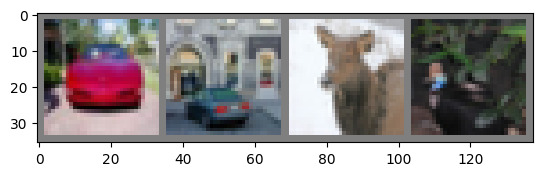

car   car   deer  bird 


In [31]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Build Neural Network: Fully Connected Only

In [32]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 2**8)
        self.fc2 = nn.Linear(2**8, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
net = Net()

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
net = net.to(device)

In [38]:
summary(net, (3,32,32), batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [4, 256]         786,688
            Linear-2                    [4, 84]          21,588
            Linear-3                    [4, 10]             850
Total params: 809,126
Trainable params: 809,126
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.01
Params size (MB): 3.09
Estimated Total Size (MB): 3.14
----------------------------------------------------------------


## Set Loss Function and Optimizer

`momentum`: momentum from previous parameters -> dampens oscillations    
`weight_decay`: L2 penalty in loss function

In [39]:
criterion = nn.CrossEntropyLoss()

In [40]:
optimizer = optim.SGD(
    net.parameters(),
    lr=0.001,
#     momentum=0.9,
#     weight_decay=0.9
)

Try some other optimizers!
* Adagrad
* RMSprop
* AdaDelta
* Adam

## Train the Network

In [41]:
num_epochs = 5

In [42]:
# 오래걸림
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.230
[1,  4000] loss: 2.072
[1,  6000] loss: 1.958
[1,  8000] loss: 1.883
[1, 10000] loss: 1.828
[1, 12000] loss: 1.798
[2,  2000] loss: 1.742
[2,  4000] loss: 1.706
[2,  6000] loss: 1.688
[2,  8000] loss: 1.673
[2, 10000] loss: 1.622
[2, 12000] loss: 1.607
[3,  2000] loss: 1.573
[3,  4000] loss: 1.578
[3,  6000] loss: 1.579
[3,  8000] loss: 1.551
[3, 10000] loss: 1.546
[3, 12000] loss: 1.540
[4,  2000] loss: 1.500
[4,  4000] loss: 1.484
[4,  6000] loss: 1.488
[4,  8000] loss: 1.475
[4, 10000] loss: 1.468
[4, 12000] loss: 1.469
[5,  2000] loss: 1.425
[5,  4000] loss: 1.435
[5,  6000] loss: 1.435
[5,  8000] loss: 1.386
[5, 10000] loss: 1.413
[5, 12000] loss: 1.394
Finished Training


In [43]:
# save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the Network

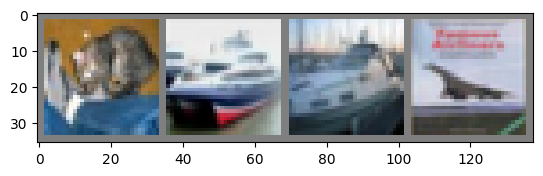

GroundTruth:  cat   ship  ship  plane


In [44]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [45]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [46]:
outputs = net(images)

In [47]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  cat   truck ship  ship 


### For the whole test dataset

In [48]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 50 %


In [49]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 53.2 %
Accuracy for class: car   is 61.8 %
Accuracy for class: bird  is 35.9 %
Accuracy for class: cat   is 29.1 %
Accuracy for class: deer  is 35.7 %
Accuracy for class: dog   is 39.5 %
Accuracy for class: frog  is 61.2 %
Accuracy for class: horse is 57.6 %
Accuracy for class: ship  is 63.9 %
Accuracy for class: truck is 64.2 %
